# **PHISHING WEBSITE DETECTION**

### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D

In [5]:
import os

### **Load the Dataset**

In [6]:
df=pd.read_csv('/kaggle/input/dataset-harsha/phishing_website_dataset_final.csv')

In [7]:
df.head()

,url,label,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,subdomains_count,ISP,Country,Region,Hostname,Location,hostname_length,ISP_Rank,Country_Rank,Region_Rank
0,http://www.m.servlces.runescape.com-mv.ru/,1,0,1,1,5,1,0,1,0,...,4,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
1,https://www.facebook.com/photo?fbid=3037752120...,0,0,1,1,3,1,0,1,0,...,1,"AS32934 Facebook, Inc.",IN,Tamil Nadu,edge-star-mini-shv-01-tir3.facebook.com,"13.0878, 80.2785",39,7.0,2.0,2.0
2,https://www.creusot-montceau.org/,0,0,1,1,2,1,0,1,0,...,0,AS16276 OVH SAS,FR,Hauts-de-France,cluster031.hosting.ovh.net,"50.6942, 3.1746",26,10.0,5.0,18.0
3,http://www.broelio.de/unternehmensphilosophie/,0,0,1,1,2,1,0,2,0,...,1,AS21499 Host Europe GmbH,FR,Grand Est,65.59.205.92.host.secureserver.net,"48.5839, 7.7455",34,51.0,5.0,40.0
4,https://www.vetassess.com.au/skills-assessment...,0,0,1,1,3,1,0,2,0,...,1,"AS54113 Fastly, Inc.",US,California,NaN,"37.7621, -122.3971",3,6.0,1.0,1.0


## **Familiarizing with Data**

In [8]:
df.shape

(20000, 39)

In [9]:
columns_to_keep = ['url']
columns_to_drop = df.select_dtypes(include=['object']).columns.difference(columns_to_keep)
df = df.drop(columns=columns_to_drop)

In [10]:
df.columns

Index(['url', 'label', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'primary_domain_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length', 'TLD_Rank',
       'has_suspicious_patterns', 'Has_IP_Address', 'subdomains_count',
       'hostname_length', 'ISP_Rank', 'Country_Rank', 'Region_Rank'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   url                      20000 non-null  object 
 1   label                    20000 non-null  int64  
 2   use_of_ip                20000 non-null  int64  
 3   abnormal_url             20000 non-null  int64  
 4   google_index             20000 non-null  int64  
 5   count.                   20000 non-null  int64  
 6   count-www                20000 non-null  int64  
 7   count@                   20000 non-null  int64  
 8   count_dir                20000 non-null  int64  
 9   count_embed_domian       20000 non-null  int64  
 10  short_url                20000 non-null  int64  
 11  count-https              20000 non-null  int64  
 12  count-http               20000 non-null  int64  
 13  count%                   20000 non-null  int64  
 14  count?                

In [12]:
X = df.drop('label', axis=1)
y = df['label']

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

X[categorical_cols] = X[categorical_cols].apply(lambda col: pd.factorize(col)[0])

imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

threshold = 0.4
X = pd.DataFrame(X_imputed, columns=numeric_cols.tolist() + categorical_cols.tolist())
X = X.loc[:, X.isnull().mean() < threshold]

print("Data shape after imputation:", X.shape)

Data shape after imputation: (20000, 31)


## **Visualizing the data**

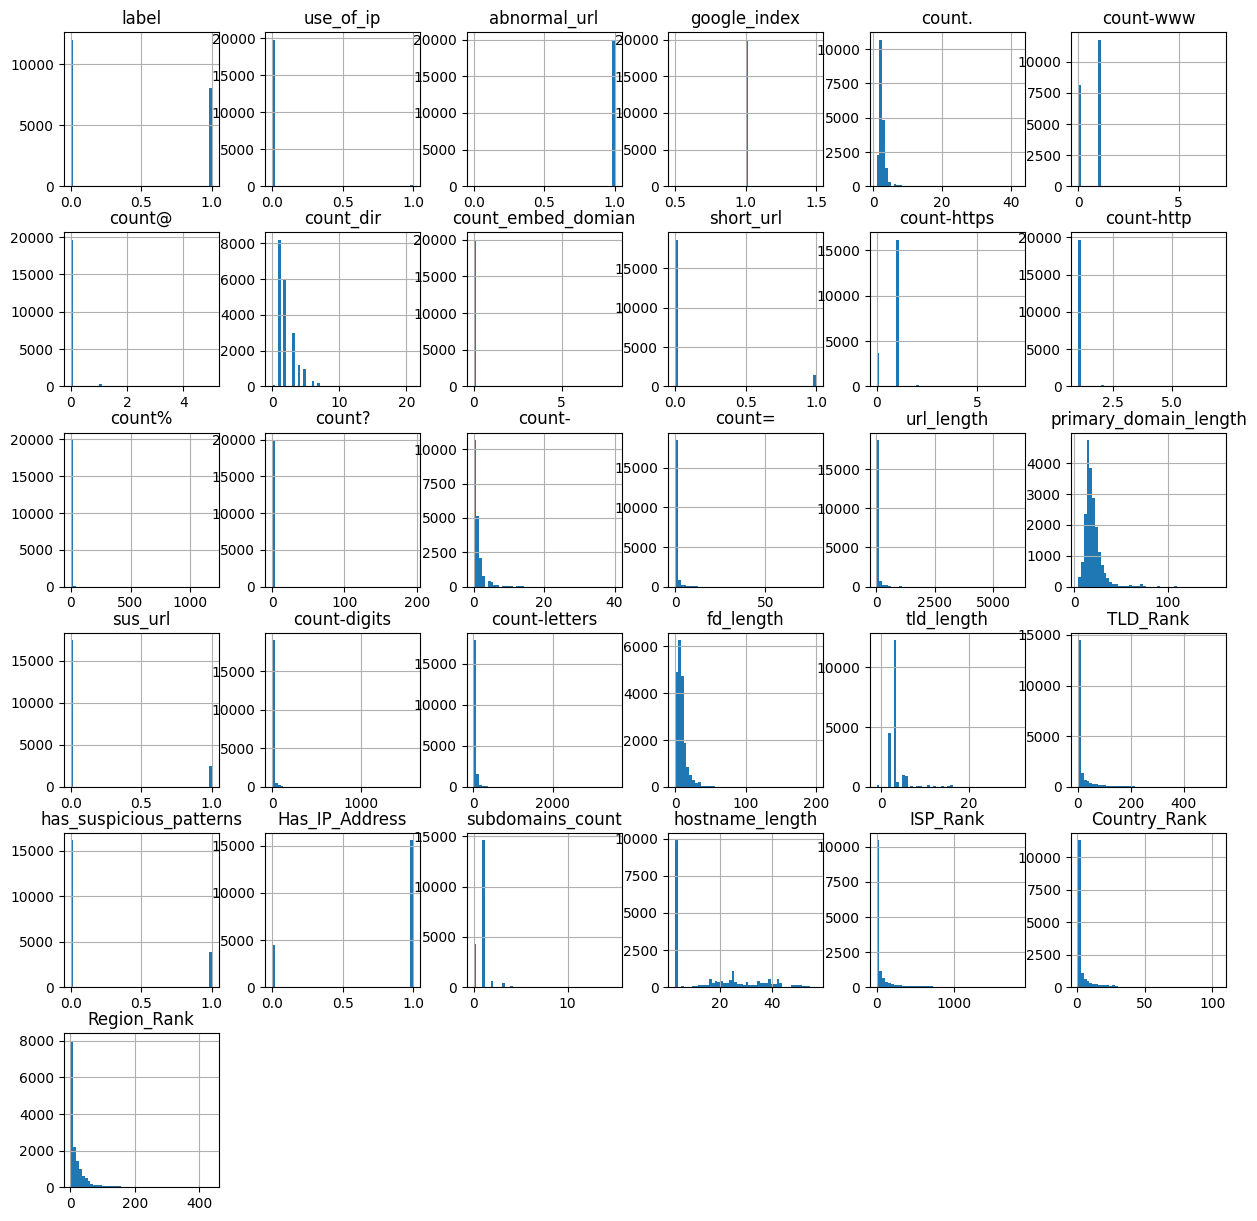

In [13]:
df.hist(bins = 50,figsize = (15,15))
plt.show()

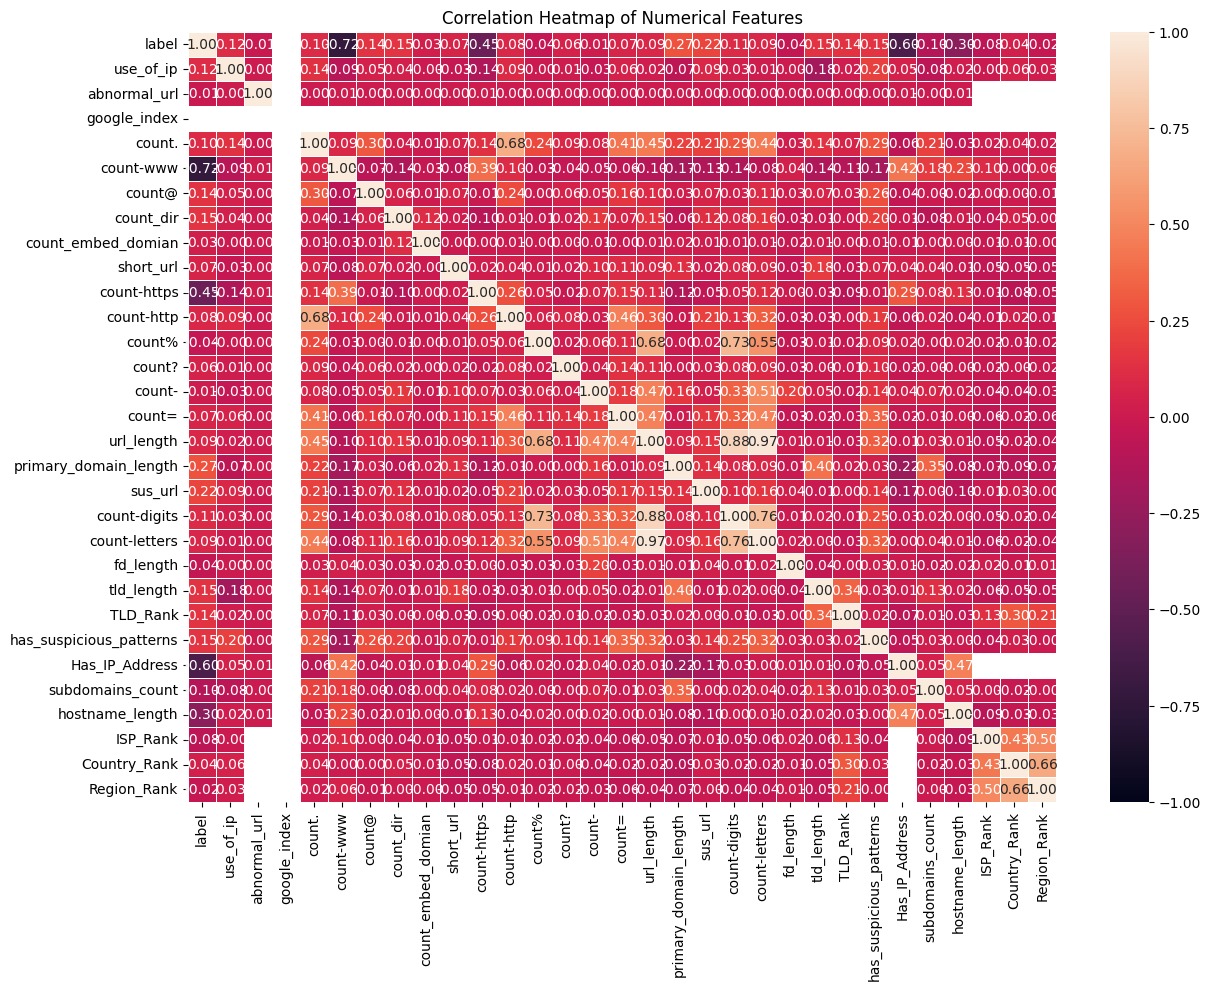

In [14]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

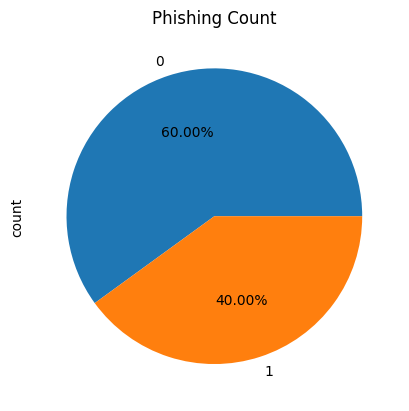

In [15]:
df['label'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

## **Data Preprocessing & EDA**

In [16]:
df.describe()

,label,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,...,fd_length,tld_length,TLD_Rank,has_suspicious_patterns,Has_IP_Address,subdomains_count,hostname_length,ISP_Rank,Country_Rank,Region_Rank
count,20000.00000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,19816.000000,20000.000000,20000.000000,20000.000000,20000.000000,15554.000000,15569.000000,15570.000000
mean,0.40000,0.009250,0.999950,1.0,2.540750,0.596050,0.020100,2.156300,0.002400,0.070650,...,8.315500,3.355550,23.502927,0.194100,0.778650,0.880450,16.275600,148.578758,5.123707,26.377906
std,0.48991,0.095733,0.007071,0.0,1.887808,0.502083,0.156196,1.447817,0.084821,0.256246,...,9.061218,2.209429,61.005774,0.395516,0.415166,0.637321,15.185466,344.542011,9.591381,51.145033
min,0.00000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000
25%,0.00000,0.000000,1.000000,1.0,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,3.000000,1.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000
50%,0.00000,0.000000,1.000000,1.0,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,...,7.000000,3.000000,1.000000,0.000000,1.000000,1.000000,9.000000,11.000000,2.000000,9.000000
75%,1.00000,0.000000,1.000000,1.0,3.000000,1.000000,0.000000,3.000000,0.000000,0.000000,...,10.000000,3.000000,14.000000,0.000000,1.000000,1.000000,26.000000,76.000000,4.000000,28.000000
max,1.00000,1.000000,1.000000,1.0,42.000000,7.000000,5.000000,21.000000,8.000000,1.000000,...,200.000000,31.000000,533.000000,1.000000,1.000000,15.000000,57.000000,1820.000000,105.000000,439.000000


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [18]:
X_scaled.shape

(20000, 31)

In [19]:
df.head()

,url,label,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,fd_length,tld_length,TLD_Rank,has_suspicious_patterns,Has_IP_Address,subdomains_count,hostname_length,ISP_Rank,Country_Rank,Region_Rank
0,http://www.m.servlces.runescape.com-mv.ru/,1,0,1,1,5,1,0,1,0,...,0,2,5.0,1,0,4,3,NaN,NaN,NaN
1,https://www.facebook.com/photo?fbid=3037752120...,0,0,1,1,3,1,0,1,0,...,5,3,1.0,0,1,1,39,7.0,2.0,2.0
2,https://www.creusot-montceau.org/,0,0,1,1,2,1,0,1,0,...,0,3,2.0,0,1,0,26,10.0,5.0,18.0
3,http://www.broelio.de/unternehmensphilosophie/,0,0,1,1,2,1,0,2,0,...,23,2,3.0,0,1,1,34,51.0,5.0,40.0
4,https://www.vetassess.com.au/skills-assessment...,0,0,1,1,3,1,0,2,0,...,31,6,14.0,1,1,1,3,6.0,1.0,1.0


## **Splitting the Data**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((16000, 31), (4000, 31))

### **Applying smote**

In [21]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# **Machine Learning Models**

**For each of the Machine Learning algorithms two experiments were conducted: one without SMOTE and one with SMOTE oversampling to address class imbalance**

In [22]:
# Creating holders to store the model performance results
Model_Name = []
accuracy_train = []
accuracy_test = []

#function to call for storing the results
def storeResults_without_smote(model, a,b):
  Model_Name.append(model)
  accuracy_train.append(round(a, 3))
  accuracy_test.append(round(b, 3))

In [23]:
Model_name_with_smote = []
accuracy_train_with_smote = []
accuracy_test_with_smote = []

#function to call for storing the results
def storeResults_with_smote(model, a,b):
  Model_name_with_smote.append(model)
  accuracy_train_with_smote.append(round(a, 3))
  accuracy_test_with_smote.append(round(b, 3))

## **Logistic Regression**

In [24]:
model_without_smote = LogisticRegression()
model_without_smote.fit(X_train, y_train)

y_train_pred=model_without_smote.predict(X_train)
training_accuracy_without_smote=accuracy_score(y_train,y_train_pred)
print(f'Training Accuracy: {training_accuracy_without_smote:.2f}')

y_pred_without_smote = model_without_smote.predict(X_test)

accuracy_without_smote = accuracy_score(y_test, y_pred_without_smote)
print(f'Accuracy: {accuracy_without_smote:.2f}')

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_without_smote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_without_smote))

Training Accuracy: 0.92
Accuracy: 0.92

Confusion Matrix:
[[2280  120]
 [ 186 1414]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2400
           1       0.92      0.88      0.90      1600

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [25]:
model_with_smote = LogisticRegression(max_iter=1000)


model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred = model_with_smote.predict(X_train_resampled)

training_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred)
print(f'Training Accuracy: {training_accuracy_with_smote:.2f}')

y_pred_with_smote = model_with_smote.predict(X_test)

accuracy_with_smote = accuracy_score(y_test, y_pred_with_smote)
print(f'Accuracy: {accuracy_with_smote:.2f}')

print("Classification Report:")
print(classification_report(y_test, y_pred_with_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_with_smote))

Training Accuracy: 0.93
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2400
           1       0.88      0.94      0.91      1600

    accuracy                           0.93      4000
   macro avg       0.92      0.93      0.92      4000
weighted avg       0.93      0.93      0.93      4000

Confusion Matrix:
[[2200  200]
 [  95 1505]]


In [26]:
storeResults_without_smote('Logistic Regression',training_accuracy_without_smote,accuracy_without_smote)
storeResults_with_smote('Logistic Regression',training_accuracy_with_smote,accuracy_with_smote)

## **Support Vector Machine Classifier**

In [27]:
svm_model_without_smote = SVC(kernel='rbf', random_state=42)

svm_model_without_smote.fit(X_train, y_train)

y_train_pred_without_smote = svm_model_without_smote.predict(X_train)
y_test_pred_without_smote = svm_model_without_smote.predict(X_test)

train_accuracy_without_smote = accuracy_score(y_train, y_train_pred_without_smote)
test_accuracy_without_smote = accuracy_score(y_test, y_test_pred_without_smote)

print("SVM without SMOTE - Training Accuracy:", train_accuracy_without_smote)
print("SVM without SMOTE - Test Accuracy:", test_accuracy_without_smote)

print("\nConfusion Matrix (without SMOTE):\n", confusion_matrix(y_test, y_test_pred_without_smote))
print("\nClassification Report (without SMOTE):\n", classification_report(y_test, y_test_pred_without_smote))

SVM without SMOTE - Training Accuracy: 0.94925
SVM without SMOTE - Test Accuracy: 0.94675

Confusion Matrix (without SMOTE):
 [[2274  126]
 [  87 1513]]

Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2400
           1       0.92      0.95      0.93      1600

    accuracy                           0.95      4000
   macro avg       0.94      0.95      0.94      4000
weighted avg       0.95      0.95      0.95      4000



In [28]:
svm_model_with_smote = SVC(kernel='rbf', random_state=42)

svm_model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_with_smote = svm_model_with_smote.predict(X_train_resampled)
y_test_pred_with_smote = svm_model_with_smote.predict(X_test)

train_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred_with_smote)
test_accuracy_with_smote = accuracy_score(y_test, y_test_pred_with_smote)

print("\nSVM with SMOTE - Training Accuracy:", train_accuracy_with_smote)
print("SVM with SMOTE - Test Accuracy:", test_accuracy_with_smote)

print("\nConfusion Matrix (with SMOTE):\n", confusion_matrix(y_test, y_test_pred_with_smote))
print("\nClassification Report (with SMOTE):\n", classification_report(y_test, y_test_pred_with_smote))


SVM with SMOTE - Training Accuracy: 0.9500520833333334
SVM with SMOTE - Test Accuracy: 0.9465

Confusion Matrix (with SMOTE):
 [[2243  157]
 [  57 1543]]

Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      2400
           1       0.91      0.96      0.94      1600

    accuracy                           0.95      4000
   macro avg       0.94      0.95      0.94      4000
weighted avg       0.95      0.95      0.95      4000



In [29]:
storeResults_without_smote('Support Vector Machine',train_accuracy_without_smote,test_accuracy_without_smote)
storeResults_with_smote('Support Vector Machine',train_accuracy_with_smote,test_accuracy_with_smote)

## **Random Forest Classifier**

In [30]:
rf_model_without_smote = RandomForestClassifier(random_state=42)

rf_model_without_smote.fit(X_train, y_train)

y_train_pred_without_smote = rf_model_without_smote.predict(X_train)
y_test_pred_without_smote = rf_model_without_smote.predict(X_test)

train_accuracy_without_smote = accuracy_score(y_train, y_train_pred_without_smote)
test_accuracy_without_smote = accuracy_score(y_test, y_test_pred_without_smote)

print("Random Forest without SMOTE - Training Accuracy:", train_accuracy_without_smote)
print("Random Forest without SMOTE - Test Accuracy:", test_accuracy_without_smote)

print("\nConfusion Matrix (without SMOTE):\n", confusion_matrix(y_test, y_test_pred_without_smote))
print("\nClassification Report (without SMOTE):\n", classification_report(y_test, y_test_pred_without_smote))

Random Forest without SMOTE - Training Accuracy: 1.0
Random Forest without SMOTE - Test Accuracy: 0.96525

Confusion Matrix (without SMOTE):
 [[2318   82]
 [  57 1543]]

Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2400
           1       0.95      0.96      0.96      1600

    accuracy                           0.97      4000
   macro avg       0.96      0.97      0.96      4000
weighted avg       0.97      0.97      0.97      4000



In [31]:
rf_model_with_smote = RandomForestClassifier(random_state=42)

rf_model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_with_smote = rf_model_with_smote.predict(X_train_resampled)
y_test_pred_with_smote = rf_model_with_smote.predict(X_test)

train_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred_with_smote)
test_accuracy_with_smote = accuracy_score(y_test, y_test_pred_with_smote)

print("\nRandom Forest with SMOTE - Training Accuracy:", train_accuracy_with_smote)
print("Random Forest with SMOTE - Test Accuracy:", test_accuracy_with_smote)

print("\nConfusion Matrix (with SMOTE):\n", confusion_matrix(y_test, y_test_pred_with_smote))
print("\nClassification Report (with SMOTE):\n", classification_report(y_test, y_test_pred_with_smote))


Random Forest with SMOTE - Training Accuracy: 1.0
Random Forest with SMOTE - Test Accuracy: 0.96525

Confusion Matrix (with SMOTE):
 [[2313   87]
 [  52 1548]]

Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2400
           1       0.95      0.97      0.96      1600

    accuracy                           0.97      4000
   macro avg       0.96      0.97      0.96      4000
weighted avg       0.97      0.97      0.97      4000



In [32]:
storeResults_without_smote('Random Forest',train_accuracy_without_smote,test_accuracy_without_smote)
storeResults_with_smote('Random Forest',train_accuracy_with_smote,test_accuracy_with_smote)

## **Decision Tree Classifier**

In [33]:
dt_model_without_smote = DecisionTreeClassifier(random_state=42)

dt_model_without_smote.fit(X_train, y_train)

y_train_pred_without_smote = dt_model_without_smote.predict(X_train)
y_test_pred_without_smote = dt_model_without_smote.predict(X_test)

train_accuracy_without_smote = accuracy_score(y_train, y_train_pred_without_smote)
test_accuracy_without_smote = accuracy_score(y_test, y_test_pred_without_smote)

print("Decision Tree without SMOTE - Training Accuracy:", train_accuracy_without_smote)
print("Decision Tree without SMOTE - Test Accuracy:", test_accuracy_without_smote)

print("\nConfusion Matrix (without SMOTE):\n", confusion_matrix(y_test, y_test_pred_without_smote))
print("\nClassification Report (without SMOTE):\n", classification_report(y_test, y_test_pred_without_smote))

Decision Tree without SMOTE - Training Accuracy: 1.0
Decision Tree without SMOTE - Test Accuracy: 0.9375

Confusion Matrix (without SMOTE):
 [[2282  118]
 [ 132 1468]]

Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2400
           1       0.93      0.92      0.92      1600

    accuracy                           0.94      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.94      0.94      4000



In [34]:
dt_model_with_smote = DecisionTreeClassifier(random_state=42)

dt_model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_with_smote = dt_model_with_smote.predict(X_train_resampled)
y_test_pred_with_smote = dt_model_with_smote.predict(X_test)

train_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred_with_smote)
test_accuracy_with_smote = accuracy_score(y_test, y_test_pred_with_smote)

print("\nDecision Tree with SMOTE - Training Accuracy:", train_accuracy_with_smote)
print("Decision Tree with SMOTE - Test Accuracy:", test_accuracy_with_smote)

print("\nConfusion Matrix (with SMOTE):\n", confusion_matrix(y_test, y_test_pred_with_smote))
print("\nClassification Report (with SMOTE):\n", classification_report(y_test, y_test_pred_with_smote))


Decision Tree with SMOTE - Training Accuracy: 1.0
Decision Tree with SMOTE - Test Accuracy: 0.94225

Confusion Matrix (with SMOTE):
 [[2286  114]
 [ 117 1483]]

Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2400
           1       0.93      0.93      0.93      1600

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



In [35]:
storeResults_without_smote('Decision Tree',train_accuracy_without_smote,test_accuracy_without_smote)
storeResults_with_smote('Decision Tree',train_accuracy_with_smote,test_accuracy_with_smote)

## **AdaBoost Classifier**

In [36]:
ada_model_without_smote = AdaBoostClassifier(n_estimators=100, random_state=42)

ada_model_without_smote.fit(X_train, y_train)

y_train_pred_without_smote = ada_model_without_smote.predict(X_train)
y_test_pred_without_smote = ada_model_without_smote.predict(X_test)

train_accuracy_without_smote = accuracy_score(y_train, y_train_pred_without_smote)
test_accuracy_without_smote = accuracy_score(y_test, y_test_pred_without_smote)

print("AdaBoost without SMOTE - Training Accuracy:", train_accuracy_without_smote)
print("AdaBoost without SMOTE - Test Accuracy:", test_accuracy_without_smote)

print("\nConfusion Matrix (without SMOTE):\n", confusion_matrix(y_test, y_test_pred_without_smote))
print("\nClassification Report (without SMOTE):\n", classification_report(y_test, y_test_pred_without_smote))

AdaBoost without SMOTE - Training Accuracy: 0.94875
AdaBoost without SMOTE - Test Accuracy: 0.94825

Confusion Matrix (without SMOTE):
 [[2313   87]
 [ 120 1480]]

Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      2400
           1       0.94      0.93      0.93      1600

    accuracy                           0.95      4000
   macro avg       0.95      0.94      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [37]:
ada_model_with_smote = AdaBoostClassifier(n_estimators=100, random_state=42)

ada_model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_with_smote = ada_model_with_smote.predict(X_train_resampled)
y_test_pred_with_smote = ada_model_with_smote.predict(X_test)

train_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred_with_smote)
test_accuracy_with_smote = accuracy_score(y_test, y_test_pred_with_smote)

print("\nAdaBoost with SMOTE - Training Accuracy:", train_accuracy_with_smote)
print("AdaBoost with SMOTE - Test Accuracy:", test_accuracy_with_smote)

print("\nConfusion Matrix (with SMOTE):\n", confusion_matrix(y_test, y_test_pred_with_smote))
print("\nClassification Report (with SMOTE):\n", classification_report(y_test, y_test_pred_with_smote))


AdaBoost with SMOTE - Training Accuracy: 0.9534375
AdaBoost with SMOTE - Test Accuracy: 0.94975

Confusion Matrix (with SMOTE):
 [[2300  100]
 [ 101 1499]]

Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2400
           1       0.94      0.94      0.94      1600

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [38]:
storeResults_without_smote('AdaBoost',train_accuracy_without_smote,test_accuracy_without_smote)
storeResults_with_smote('AdaBoost',train_accuracy_with_smote,test_accuracy_with_smote)

## **Gradient Boosting Classifier**

In [39]:
gbm_model_without_smote = GradientBoostingClassifier(random_state=42)

gbm_model_without_smote.fit(X_train, y_train)

y_train_pred_without_smote = gbm_model_without_smote.predict(X_train)
y_test_pred_without_smote = gbm_model_without_smote.predict(X_test)

train_accuracy_without_smote = accuracy_score(y_train, y_train_pred_without_smote)
test_accuracy_without_smote = accuracy_score(y_test, y_test_pred_without_smote)

print("Gradient Boosting without SMOTE - Training Accuracy:", train_accuracy_without_smote)
print("Gradient Boosting without SMOTE - Test Accuracy:", test_accuracy_without_smote)

print("\nConfusion Matrix (without SMOTE):\n", confusion_matrix(y_test, y_test_pred_without_smote))
print("\nClassification Report (without SMOTE):\n", classification_report(y_test, y_test_pred_without_smote))

Gradient Boosting without SMOTE - Training Accuracy: 0.9540625
Gradient Boosting without SMOTE - Test Accuracy: 0.9525

Confusion Matrix (without SMOTE):
 [[2303   97]
 [  93 1507]]

Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2400
           1       0.94      0.94      0.94      1600

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [40]:
gbm_model_with_smote = GradientBoostingClassifier(random_state=42)

gbm_model_with_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_with_smote = gbm_model_with_smote.predict(X_train_resampled)
y_test_pred_with_smote = gbm_model_with_smote.predict(X_test)

train_accuracy_with_smote = accuracy_score(y_train_resampled, y_train_pred_with_smote)
test_accuracy_with_smote = accuracy_score(y_test, y_test_pred_with_smote)

print("\nGradient Boosting with SMOTE - Training Accuracy:", train_accuracy_with_smote)
print("Gradient Boosting with SMOTE - Test Accuracy:", test_accuracy_with_smote)

print("\nConfusion Matrix (with SMOTE):\n", confusion_matrix(y_test, y_test_pred_with_smote))
print("\nClassification Report (with SMOTE):\n", classification_report(y_test, y_test_pred_with_smote))


Gradient Boosting with SMOTE - Training Accuracy: 0.9576041666666667
Gradient Boosting with SMOTE - Test Accuracy: 0.9505

Confusion Matrix (with SMOTE):
 [[2284  116]
 [  82 1518]]

Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2400
           1       0.93      0.95      0.94      1600

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [41]:
storeResults_without_smote('Gradient Boosting',train_accuracy_without_smote,test_accuracy_without_smote)
storeResults_with_smote('Gradient Boosting',train_accuracy_with_smote,test_accuracy_with_smote)

# **Deep Learning**

## **Convolutional Neural Network (CNN)**

In [70]:
X_encoded = pd.get_dummies(X, drop_first=True)

# Check the shape of the encoded features
print("Encoded Features shape:", X_encoded.shape)

Encoded Features shape: (20000, 31)


In [71]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# Disable GPU to avoid platform issues (if needed)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Uncomment this line if you suspect GPU issues


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (16000, 31, 1)
X_test_scaled shape: (4000, 31, 1)


In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation='relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

2024-10-16 08:06:01.446744: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 55209, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27604, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27602, 32)      │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13801, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 441632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    28,264,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,271,009 (107.85 MB)

 Trainable params: 28,271,009 (107.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20

400/400 [==============================] - 280s 698ms/step - loss: 0.2421 - accuracy: 0.9159 - val_loss: 0.1657 - val_accuracy: 0.9434

Epoch 2/20

400/400 [==============================] - 274s 684ms/step - loss: 0.1229 - accuracy: 0.9591 - val_loss: 0.1561 - val_accuracy: 0.9472

Epoch 3/20

400/400 [==============================] - 273s 683ms/step - loss: 0.0537 - accuracy: 0.9820 - val_loss: 0.2280 - val_accuracy: 0.9422

Epoch 4/20

400/400 [==============================] - 277s 692ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.1972 - val_accuracy: 0.9481

Epoch 5/20

400/400 [==============================] - 276s 689ms/step - loss: 0.0099 - accuracy: 0.9965 - val_loss: 0.2640 - val_accuracy: 0.9478

Epoch 6/20

400/400 [==============================] - 273s 684ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.2407 - val_accuracy: 0.9459

Epoch 7/20

400/400 [==============================] - 274s 685ms/step - loss: 0.0047 - accuracy: 0.9978 - val_l

### **Model Evaluation for CNN**

In [ ]:
y_train_pred = (cnn_model.predict(X_train_scaled) > 0.5).astype(int)
y_test_pred = (cnn_model.predict(X_test_scaled) > 0.5).astype(int)

# Calculate accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nCNN - Training Accuracy:", train_accuracy)
print("CNN - Test Accuracy:", test_accuracy)

# Confusion matrix and classification report for test set
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

500/500 [==============================] - 92s 184ms/step

125/125 [==============================] - 23s 185ms/step



CNN - Training Accuracy: 0.989

CNN - Test Accuracy: 0.895



Confusion Matrix:

 [[2221  179]

 [ 241 1359]]



Classification Report:

               precision    recall  f1-score   support



           0       0.90      0.93      0.91      2400

           1       0.88      0.85      0.87      1600



    accuracy                           0.90      4000

   macro avg       0.89      0.89      0.89      4000

weighted avg       0.89      0.90      0.89      4000




In [ ]:
storeResults_without_smote('Convolutional Neural Network',train_accuracy_without_smote,test_accuracy_without_smote)

## **Bidirectional long short-term memory (BiLSTM)**

In [ ]:
with strategy.scope():
    bilstm_model = Sequential()

    bilstm_model.add(Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)))

    bilstm_model.add(Bidirectional(LSTM(units=50, activation='tanh')))

    bilstm_model.add(Dropout(0.5))

    bilstm_model.add(Dense(64, activation='relu'))

    bilstm_model.add(Dense(1, activation='sigmoid'))

    bilstm_model.summary()

    bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = bilstm_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

I0000 00:00:1729067041.441508    1467 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 55211, 100)     │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,729 (342.69 KB)

 Trainable params: 87,729 (342.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-10-16 08:24:18.707219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.

I0000 00:00:1729067058.969446    2276 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(be483c41a1945cfd:0:0), session_name()

I0000 00:00:1729067062.220281    2276 tpu_compile_op_common.cc:245] Compilation of be483c41a1945cfd:0:0 with session name  took 3.250787832s and succeeded

I0000 00:00:1729067062.237904    2276 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(be483c41a1945cfd:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5021872067599474348", property.function_library_fingerprint = 9734702292320192766, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z

400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8414 - loss: 0.4159

2024-10-16 08:44:25.926457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.

I0000 00:00:1729068266.018528    2267 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1e34324ec5f84b9e:0:0), session_name()

I0000 00:00:1729068267.138122    2267 tpu_compile_op_common.cc:245] Compilation of 1e34324ec5f84b9e:0:0 with session name  took 1.119541243s and succeeded

I0000 00:00:1729068267.140015    2267 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1e34324ec5f84b9e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9197551593120519600", property.function_library_fingerprint = 1458350212970310066, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1,

400/400 ━━━━━━━━━━━━━━━━━━━━ 1271s 3s/step - accuracy: 0.8415 - loss: 0.4157 - val_accuracy: 0.8900 - val_loss: 0.2740

Epoch 2/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1262s 3s/step - accuracy: 0.9003 - loss: 0.2441 - val_accuracy: 0.9050 - val_loss: 0.2340

Epoch 3/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1259s 3s/step - accuracy: 0.8974 - loss: 0.2420 - val_accuracy: 0.8900 - val_loss: 0.2526

Epoch 4/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1262s 3s/step - accuracy: 0.8789 - loss: 0.2435 - val_accuracy: 0.9150 - val_loss: 0.2147

Epoch 5/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1261s 3s/step - accuracy: 0.9169 - loss: 0.1997 - val_accuracy: 0.8875 - val_loss: 0.2982

Epoch 6/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1261s 3s/step - accuracy: 0.9214 - loss: 0.2123 - val_accuracy: 0.9225 - val_loss: 0.1981

Epoch 7/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1261s 3s/step - accuracy: 0.9396 - loss: 0.1568 - val_accuracy: 0.9275 - val_loss: 0.1871

Epoch 8/10

400/400 ━━━━━━━━━━━━━━━━━━━━ 1258s 3s/step - accuracy: 0.9232 - loss: 0.1837

### **Model evaluation for BiLSTM**

In [ ]:
y_train_pred = (bilstm_model.predict(X_train_scaled) > 0.5).astype(int)
y_test_pred = (bilstm_model.predict(X_test_scaled) > 0.5).astype(int)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nBidirectional LSTM - Training Accuracy:", train_accuracy)
print("Bidirectional LSTM - Test Accuracy:", test_accuracy)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

2024-10-16 11:55:27.432089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1/bidirectional_1/backward_lstm_1/lstm_cell_1/Cast/ReadVariableOp.

I0000 00:00:1729079727.513406    2282 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d962cc989bb85ea5:0:0), session_name()

I0000 00:00:1729079728.663913    2282 tpu_compile_op_common.cc:245] Compilation of d962cc989bb85ea5:0:0 with session name  took 1.150443144s and succeeded

I0000 00:00:1729079728.665761    2282 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d962cc989bb85ea5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_5827993686697496801", property.function_library_fingerprint = 3533514640585876538, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().

500/500 ━━━━━━━━━━━━━━━━━━━━ 308s 612ms/step

125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 613ms/step



Bidirectional LSTM - Training Accuracy: 0.9283125

Bidirectional LSTM - Test Accuracy: 0.93325



Confusion Matrix:

 [[2235  165]

 [ 102 1498]]



Classification Report:

               precision    recall  f1-score   support



           0       0.96      0.93      0.94      2400

           1       0.90      0.94      0.92      1600



    accuracy                           0.93      4000

   macro avg       0.93      0.93      0.93      4000

weighted avg       0.93      0.93      0.93      4000




In [ ]:
storeResults_without_smote('Bidirectional LSTM',train_accuracy_without_smote,test_accuracy_without_smote)

In [42]:
storeResults_without_smote('Convolutional Neural Network',0.989,0.895)
storeResults_without_smote('Bidirectional LSTM',0.928,0.933)

## **Comparision of Models**

In [43]:
results_without_smote=pd.DataFrame({'Model': Model_Name,
                                    'Train Accuracy': accuracy_train,
                                    'Test Accuracy': accuracy_test})
results_without_smote

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.924,0.924
1,Support Vector Machine,0.949,0.947
2,Random Forest,1.000,0.965
3,Decision Tree,1.000,0.938
4,AdaBoost,0.949,0.948
5,Gradient Boosting,0.954,0.952
6,Convolutional Neural Network,0.989,0.895
7,Bidirectional LSTM,0.928,0.933


In [44]:
results_with_smote=pd.DataFrame({'Model': Model_name_with_smote,
                                 'Train Accuracy': accuracy_train_with_smote,
                                 'Test Accuracy': accuracy_test_with_smote})
results_with_smote

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.927,0.926
1,Support Vector Machine,0.950,0.946
2,Random Forest,1.000,0.965
3,Decision Tree,1.000,0.942
4,AdaBoost,0.953,0.950
5,Gradient Boosting,0.958,0.950


In [45]:
results_without_smote.sort_values(by=['Test Accuracy', 'Train Accuracy'], ascending=False)

,Model,Train Accuracy,Test Accuracy
2,Random Forest,1.000,0.965
5,Gradient Boosting,0.954,0.952
4,AdaBoost,0.949,0.948
1,Support Vector Machine,0.949,0.947
3,Decision Tree,1.000,0.938
7,Bidirectional LSTM,0.928,0.933
0,Logistic Regression,0.924,0.924
6,Convolutional Neural Network,0.989,0.895


In [46]:
results_with_smote.sort_values(by=['Test Accuracy', 'Train Accuracy'], ascending=False)

,Model,Train Accuracy,Test Accuracy
2,Random Forest,1.000,0.965
5,Gradient Boosting,0.958,0.950
4,AdaBoost,0.953,0.950
1,Support Vector Machine,0.950,0.946
3,Decision Tree,1.000,0.942
0,Logistic Regression,0.927,0.926


**Storing Results in pickle file**

In [67]:
results = {
    "without_smote": {
        "train_accuracy": train_accuracy_without_smote,
        "test_accuracy": test_accuracy_without_smote,
        "confusion_matrix": confusion_matrix(y_test, y_test_pred_without_smote).tolist(),
        "classification_report": classification_report(y_test, y_test_pred_without_smote)
    },
    "with_smote": {
        "train_accuracy": train_accuracy_with_smote,
        "test_accuracy": test_accuracy_with_smote,
        "confusion_matrix": confusion_matrix(y_test, y_test_pred_with_smote).tolist(),
        "classification_report": classification_report(y_test, y_test_pred_with_smote)
    }
}

with open('random_forest_results.pkl', 'wb') as f:
    pickle.dump(results, f)

with open('rf_model_without_smote.pkl', 'wb') as f:
    pickle.dump(rf_model_without_smote, f)

with open('rf_model_with_smote.pkl', 'wb') as f:
    pickle.dump(rf_model_with_smote, f)

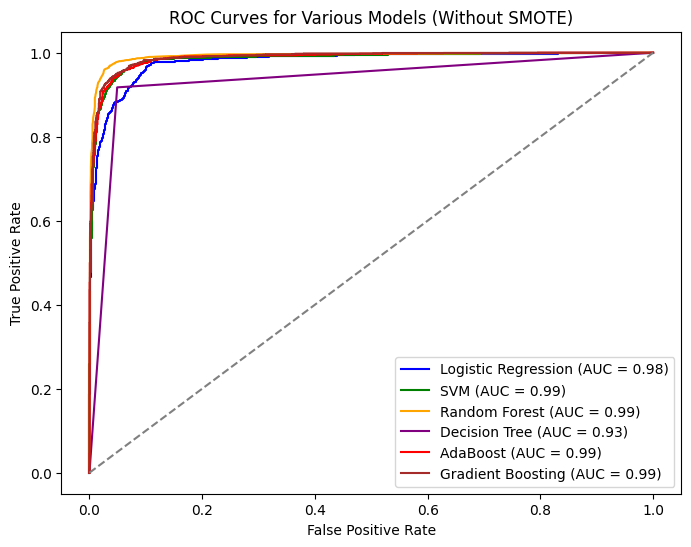

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize plot
plt.figure(figsize=(8, 6))

# Define colors for each model's curve
colors = {
    "Logistic Regression": "blue",
    "SVM": "green",
    "Random Forest": "orange",
    "Decision Tree": "purple",
    "AdaBoost": "red",
    "Gradient Boosting": "brown"
}

# Function to plot ROC curve for each model
def plot_roc_curve(model, X_test, y_test, model_name, color):
    # Check if model supports `predict_proba` method
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    else:
        # For SVM with probability=True
        y_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color, label=f'{model_name} (AUC = {auc_score:.2f})')

# Train and plot for each model
models = {
    "Logistic Regression": model_without_smote,
    "SVM": svm_model_without_smote,
    "Random Forest": rf_model_without_smote,
    "Decision Tree": dt_model_without_smote,
    "AdaBoost": ada_model_without_smote,
    "Gradient Boosting": gbm_model_without_smote
}

# Generate ROC curve for each model
for model_name, model in models.items():
    color = colors[model_name]
    plot_roc_curve(model, X_test, y_test, model_name, color)

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models (Without SMOTE)')
plt.legend(loc='lower right')
plt.show()

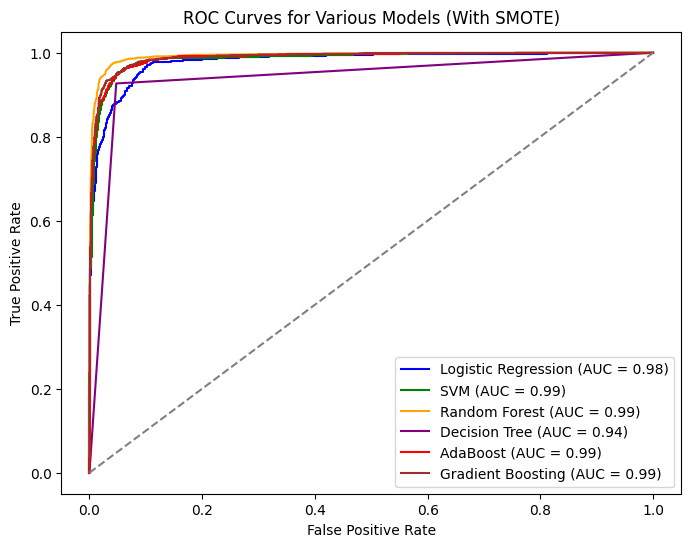

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize plot
plt.figure(figsize=(8, 6))

# Define colors for each model's curve
colors = {
    "Logistic Regression": "blue",
    "SVM": "green",
    "Random Forest": "orange",
    "Decision Tree": "purple",
    "AdaBoost": "red",
    "Gradient Boosting": "brown"
}

# Function to plot ROC curve for each model
def plot_roc_curve(model, X_test, y_test, model_name, color):
    # Check if model supports `predict_proba` method
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    else:
        # For SVM with probability=True
        y_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color, label=f'{model_name} (AUC = {auc_score:.2f})')

# Dictionary of trained models (with SMOTE)
models_with_smote = {
    "Logistic Regression": model_with_smote,
    "SVM": svm_model_with_smote,
    "Random Forest": rf_model_with_smote,
    "Decision Tree": dt_model_with_smote,
    "AdaBoost": ada_model_with_smote,
    "Gradient Boosting": gbm_model_with_smote
}

# Generate ROC curve for each model
for model_name, model in models_with_smote.items():
    color = colors[model_name]
    plot_roc_curve(model, X_test, y_test, model_name, color)

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models (With SMOTE)')
plt.legend(loc='lower right')
plt.show()
